Fútbol Match Highlights<br>
Source Face Embedding - Capstone 2<br>
Tom Widdows

This is the final preparation step before recognizing faces. This notebook: 
- Detects faces in an image
- Removes non-faces - Face vs Object (non-face) model previously trained
- Removes blurry images - Focused vs Unfocused model previously trained
- Calculates and saves 128 dimention vector for describing the face
- Calculates and saves other information about the faces (nose position, skin tones...)

Next will be face recognition.

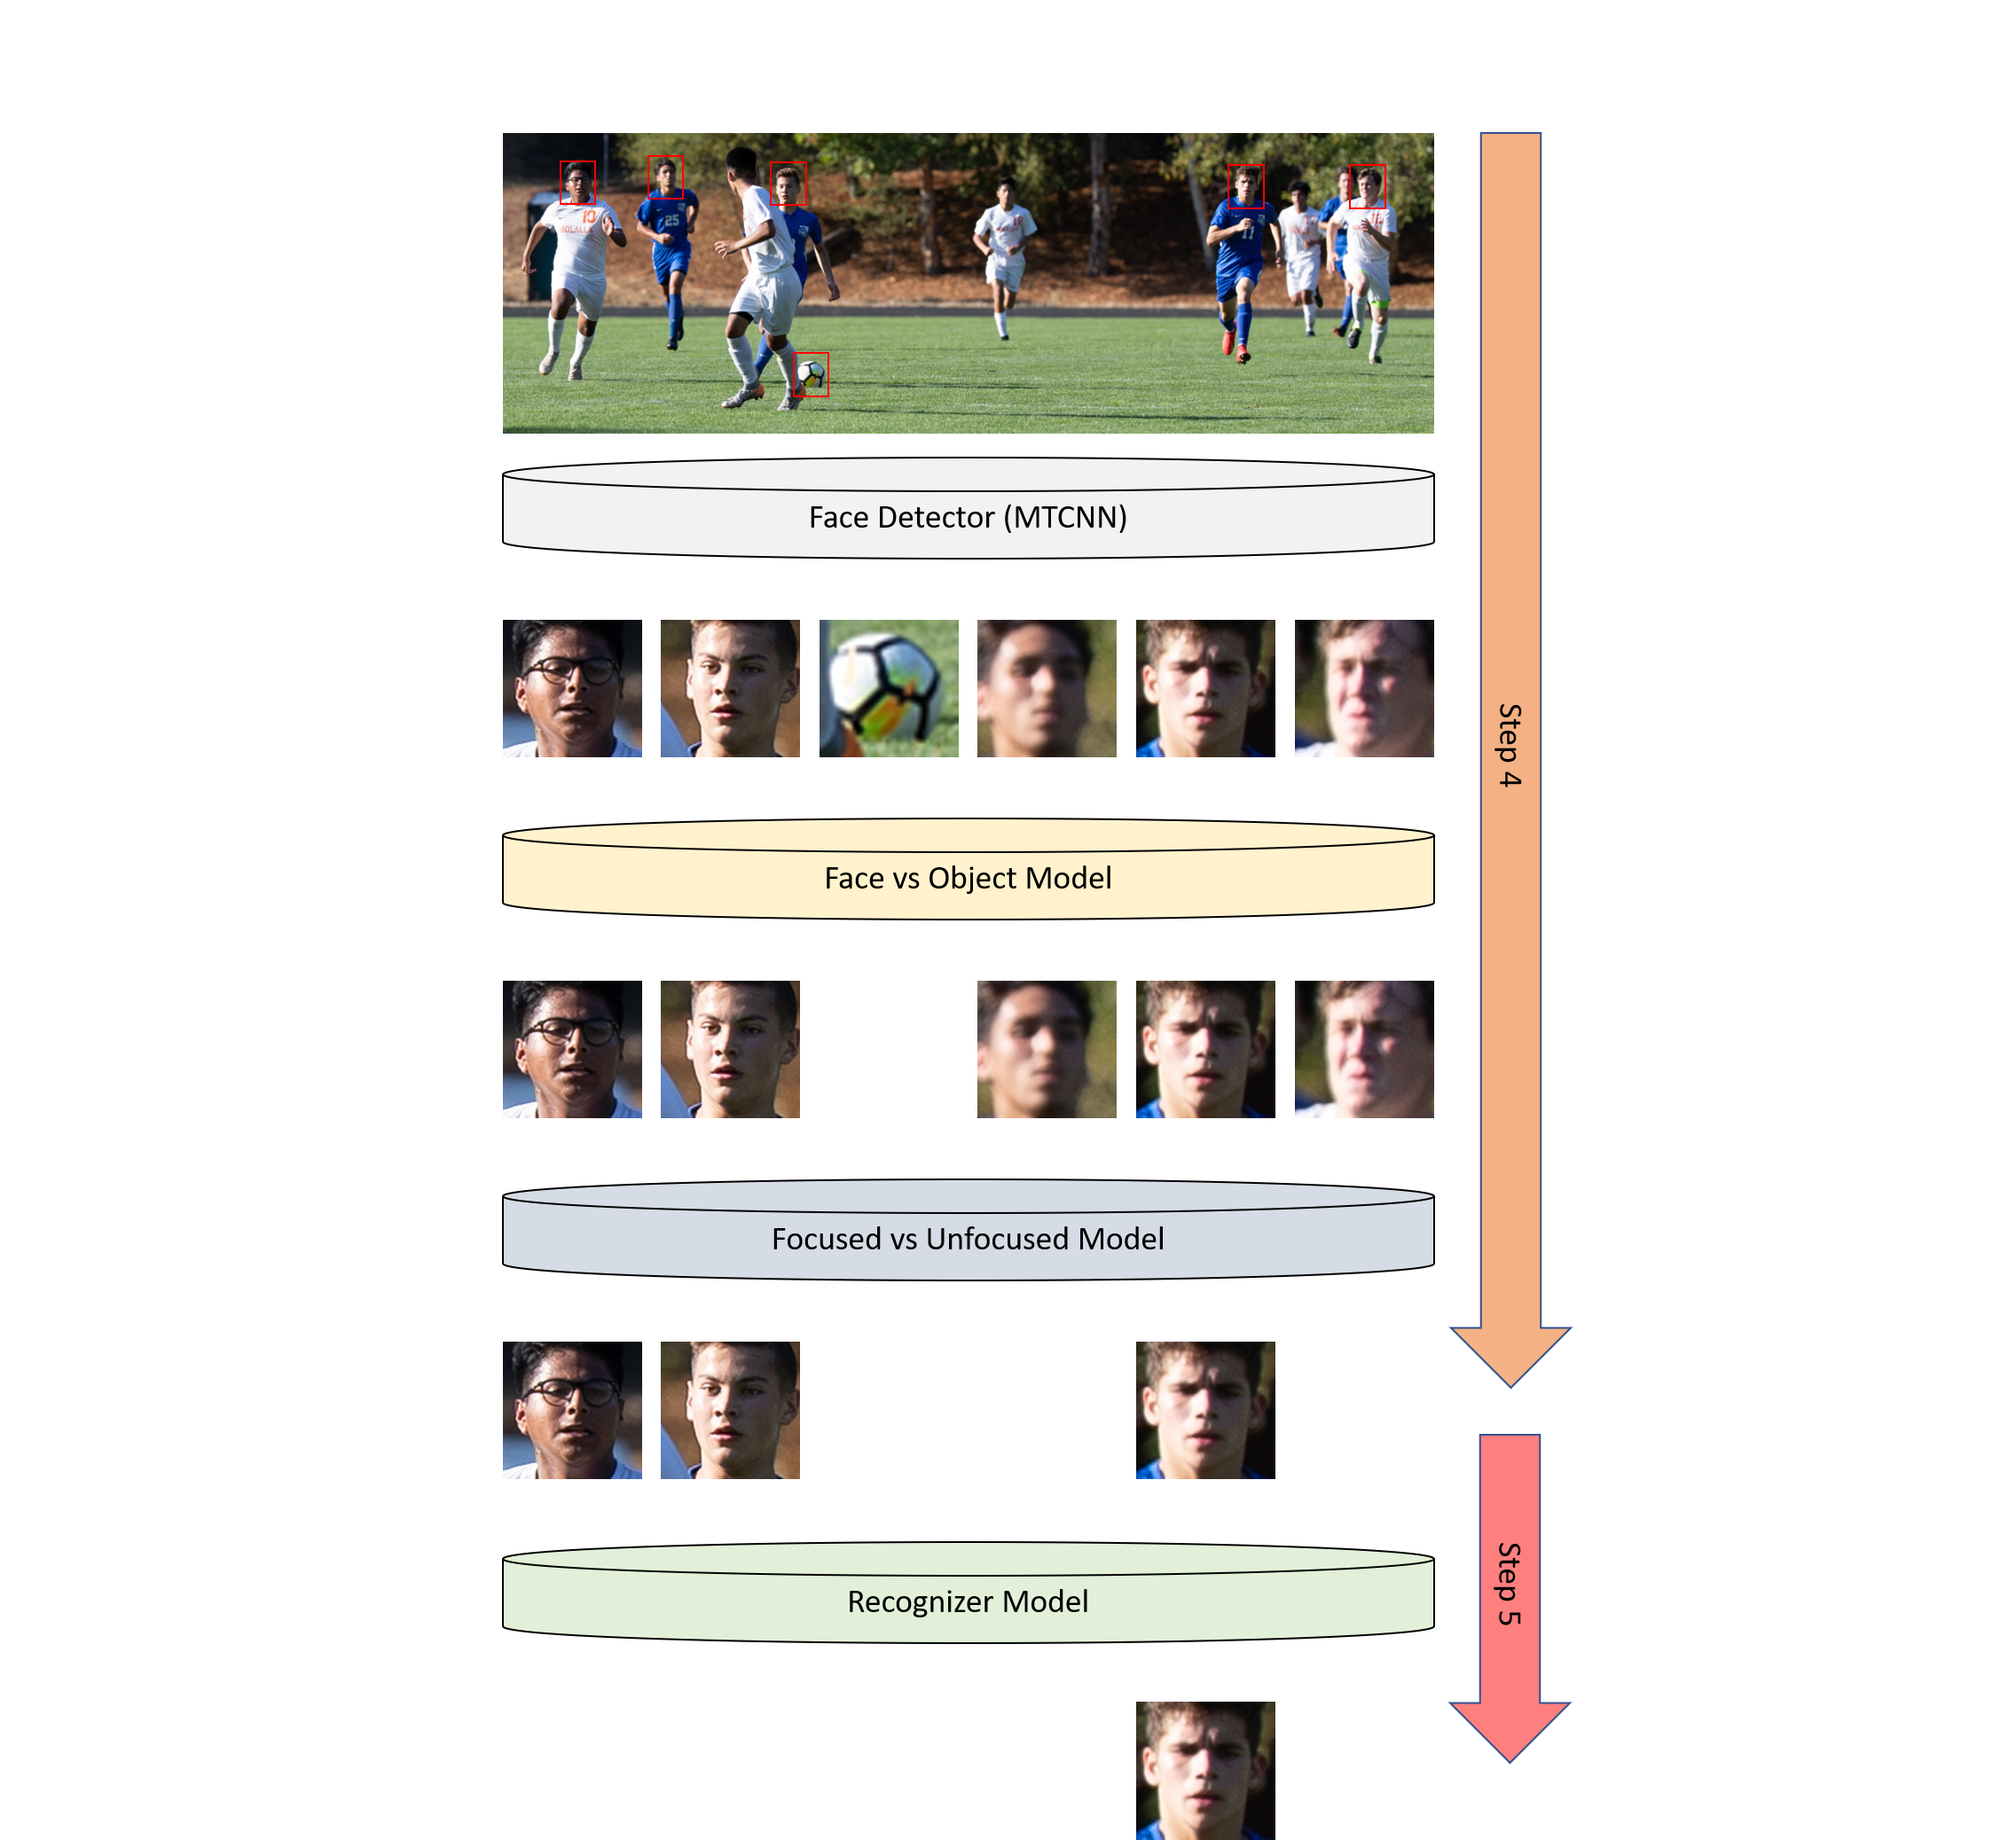

##### Housekeeping...

In [1]:
import sys
sys.path.append('../code')
import settings as s

import cv2
from mtcnn import MTCNN
import numpy as np 
import pandas as pd 
from pathlib import Path
import pickle
import random
import shutil
import time

from support_class import Fball, FaceAligner, time_it

start_all = time.time()  # track time for notebook to run

%matplotlib inline

Using TensorFlow backend.


##### Common variables and settings...

In [2]:
# common variables used throughout the notebook
random.seed(14)

##### Get files

In [3]:
path_file = [f_name for d_name in Path(s.SOURCE / 'extended').glob("*") for f_name in d_name.glob('*') if d_name.is_dir() if f_name.is_file() if f_name.suffix=='.jpg']
file_names = [Path(f).name for f in path_file]
dir_names = [Path(f).parent for f in path_file]
df_s = pd.DataFrame(zip(file_names, dir_names, path_file), columns=['file','path','path_file'])

##### Load Focused vs Unfocused Model

In [4]:
focused_vs_unfocused_model = Fball.load_model('extended_focused_vs_unfocused_model', ir=False)
focused_vs_unfocused_scaler = Fball.load_model('extended_focused_vs_unfocused_scaler', ir=False)

##### Load Face vs Object (non-face) Model

In [5]:
face_vs_object_model = Fball.load_model('extended_face_vs_object_model', ir=False)
face_vs_object_scaler = Fball.load_model('extended_face_vs_object_scaler', ir=False) 

##### Dectect faces, remove non-faces, remove blurry faces, calculate vector describing face

In [6]:
# Dectect faces, remove non-faces, remove blurry faces, calculate vector describing face

def find_mtcnn_faces():
    embedder = cv2.dnn.readNetFromTorch(str(s.MODELS / 'openface_nn4.small2.v1.t7'))
    detector = MTCNN()  # we are finding this on the scaled image and storing points based on the scaled image
    fa = FaceAligner(desired_face_width=256)

    files=[]
    processed_files = df_s['path_file']
    for file in processed_files:
        pickle_dir = file.parent / 'mtcnn_faces' / 'mtcnn_pickles' 
        if len(list(pickle_dir.glob(file.stem + '*' + '.pkl'))) == 0:  # get only the files that have not been processed
            files.append(file)
            
    for file in files:  # premake directories
        Path(file.parent / 'images_with_no_faces').mkdir(parents=True, exist_ok=True)
        Path(file.parent / 'mtcnn_faces' / 'mtcnn_pickles').mkdir(parents=True, exist_ok=True)
        Path(file.parent / 'mtcnn_faces' / 'mtcnn_blury').mkdir(parents=True, exist_ok=True)
        Path(file.parent / 'mtcnn_faces' / 'mtcnn_not_face').mkdir(parents=True, exist_ok=True)
            
    for c, file in enumerate(files):  # reads an image (photograph) with multiple faces
        print(str(c+1) + ' of ' + str(len(files)) + '  '+ file.name + '                    ', end='\r')
        image = cv2.imread(str(file))
        result = detector.detect_faces(image) # detct the faces
        
        result_count = len(result)
        if result_count == 0: # no faces found in entire image, move image and gt pickle, move to next image
            f = file.parent / 'images_with_no_faces' / file.name
            shutil.move(file, f)
            if file.with_suffix('.pkl').is_file():
                shutil.move(file.with_suffix('.pkl'), f.with_suffix('.pkl'))
            continue # move to next image
            
        for i, face in enumerate(result):  # loop through detected faces
            (x, y, w, h) = face['box']
            rect = [x,y,w,h]
            # align the face for better recognition
            face_aligned = fa.align(image, rect, face['keypoints']['left_eye'], face['keypoints']['right_eye'])
            face_file = file.parent / 'mtcnn_faces' / (file.stem + '_faceno_' + str(i).zfill(4)+'.jpg')
#             cv2.imshow('x', face_aligned)
#             cv2.waitKey(0)
            
            # check for face with trained model
            gray_face_aligned = cv2.cvtColor(face_aligned, cv2.COLOR_BGR2GRAY)
            X = cv2.resize(gray_face_aligned, (64,64)).flatten()
            X = face_vs_object_scaler.transform([X])
            pred = face_vs_object_model.predict_proba(X)[0]  # predict if face or object
            if pred[0] > .20:  # [0] is no face percent, [1] is face percent, .20 is model cutoff
                f = file.parent / 'mtcnn_faces' / 'mtcnn_not_face' / face_file.name
                cv2.imwrite(str(f), face_aligned)
                result_count = result_count - 1
                if result_count == 0: # no faces found in entire image, move image and gt pickle, move to next image
                    f = file.parent / 'images_with_no_faces' / file.name
                    shutil.move(file, f)                    
                    if file.with_suffix('.pkl').is_file():
                        shutil.move(file.with_suffix('.pkl'), f.with_suffix('.pkl'))
                continue
                
            # check for focus with trained model
            X = Fball.get_sharp_data(gray_face_aligned)
            X = focused_vs_unfocused_scaler.transform([X])
            pred = focused_vs_unfocused_model.predict_proba(X)[0]  #predict
            if pred[0] > .80:  # if blur % is > 22, consider the photo blurry (same as preds[1] <= 78)
                f = file.parent / 'mtcnn_faces' / 'mtcnn_blury' / face_file.name
                cv2.imwrite(str(f), face_aligned)
                result_count = result_count - 1
                if result_count == 0: # no faces found in entire image, move image and gt pickle, move to next image
                    f = file.parent / 'images_with_no_faces' / file.name
                    shutil.move(file, f)
                    if file.with_suffix('.pkl').is_file():
                        shutil.move(file.with_suffix('.pkl'), f.with_suffix('.pkl'))
                continue
           
            # store information (some for future enhancements)
            confidence = face['confidence']
            org_image_left_eye = face['keypoints']['left_eye']
            org_image_right_eye = face['keypoints']['right_eye']
            org_image_nose = face['keypoints']['nose']
            org_image_mouth_left = face['keypoints']['mouth_left']
            org_image_mouth_right = face['keypoints']['mouth_right']
            face_image_left_eye = tuple(np.subtract(org_image_left_eye, (x, y)))
            face_image_right_eye = tuple(np.subtract(org_image_right_eye, (x, y)))
            face_image_nose = tuple(np.subtract(org_image_nose, (x, y)))
            face_image_mouth_left = tuple(np.subtract(org_image_mouth_left, (x, y)))
            face_image_mouth_right = tuple(np.subtract(org_image_mouth_right, (x, y)))
            face_pickle = file.parent / 'mtcnn_faces' /'mtcnn_pickles'/ (file.stem + '_faceno_' + str(i).zfill(4)+'.pkl')
            vec = Fball.get_face_embedding(face_aligned, embedder)
            skin_tone_pct = Fball.skin_tone(face_aligned)
            cv2.imwrite(str(face_file), face_aligned)
            dict = {'face_file':face_file, 'path_file':file, 'faceno':str(i).zfill(4), 'faceno_int':i, 'x1':x, 'y1':y, 'x2': x+w, 'y2':y+h, 'w':w, 'h':h, 'confidence':confidence, 'sq_pixels': w*h,  'org_image_h': image.shape[0], 'org_image_w':image.shape[1], 'org_image_sq_pixels':image.shape[0] * image.shape[1], 'face_pct': (w*h)/(image.shape[0] * image.shape[1]), 'org_image_left_eye':org_image_left_eye, 'org_image_right_eye':org_image_right_eye, 'org_image_nose':org_image_nose, 'org_image_mouth_left':org_image_mouth_left, 'org_image_mouth_right':org_image_mouth_right, 'face_image_left_eye':face_image_left_eye, 'face_image_right_eye':face_image_right_eye, 'face_image_nose':face_image_nose, 'face_image_mouth_left':face_image_mouth_left, 'face_image_mouth_right':face_image_mouth_right, 'skin_tone_pct':skin_tone_pct, 'vec':[vec]}
            with open(face_pickle, 'wb') as handle:
                pickle.dump(dict, handle)
    return 

# face detection using MTCNN classifier
find_mtcnn_faces()
print('\nDone')


Done


In [7]:
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start_all)))}')

00:00:00
